In [2]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [3]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [4]:
# Selected features 
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']


# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Host Response Rate,Accommodates,Bathrooms,Bedrooms,Beds,...,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,x,y,z,text_encoding_tsne_1,text_encoding_tsne_2
27357,3,4,2.45,1,23,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208824,-0.728089,0.652900,-7.517027,-0.076676
17998,1,35,2.75,10,156,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208893,-0.728482,0.652440,-7.517027,-0.076676
11703,3,16,0.62,4,37,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209660,-0.728891,0.651737,-7.517027,-0.076676
25026,1,0,0.00,10,284,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208956,-0.727793,0.653188,-7.517027,-0.076676
31283,1,0,0.00,1,43,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209579,-0.728689,0.651989,-7.517027,-0.076676


# Hist Gradient Boosting Regressor

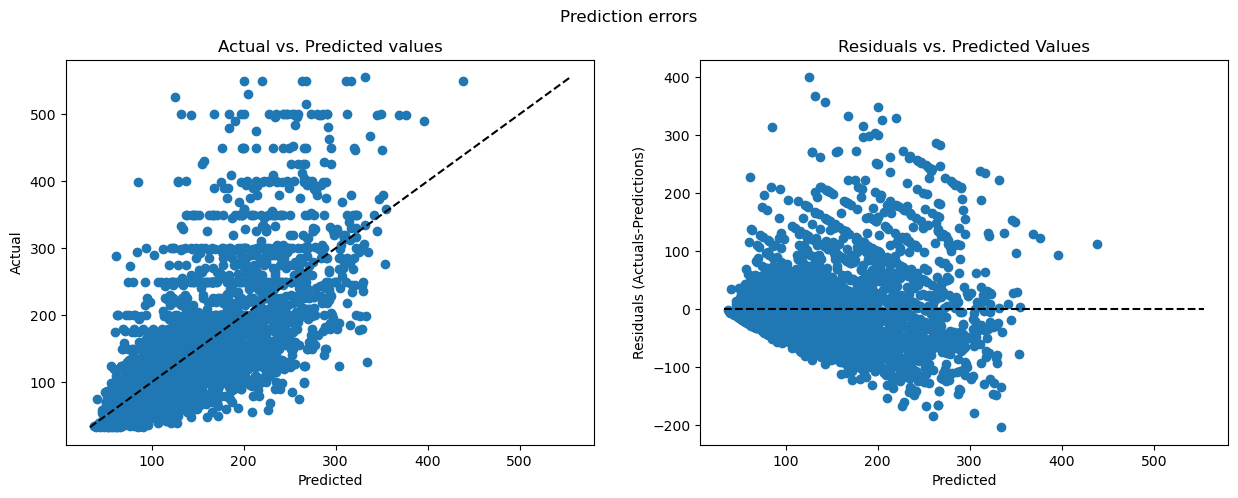

R²: 0.5531535768731235
MAE: 41.81007499211083
MSE: 3997.605324076273
RMSE: 63.226618793640014
MAPE: 0.32739174349394223
error_ratio_rmse: 0.45713872844673015
error_ratio_mae: 0.302293636490942


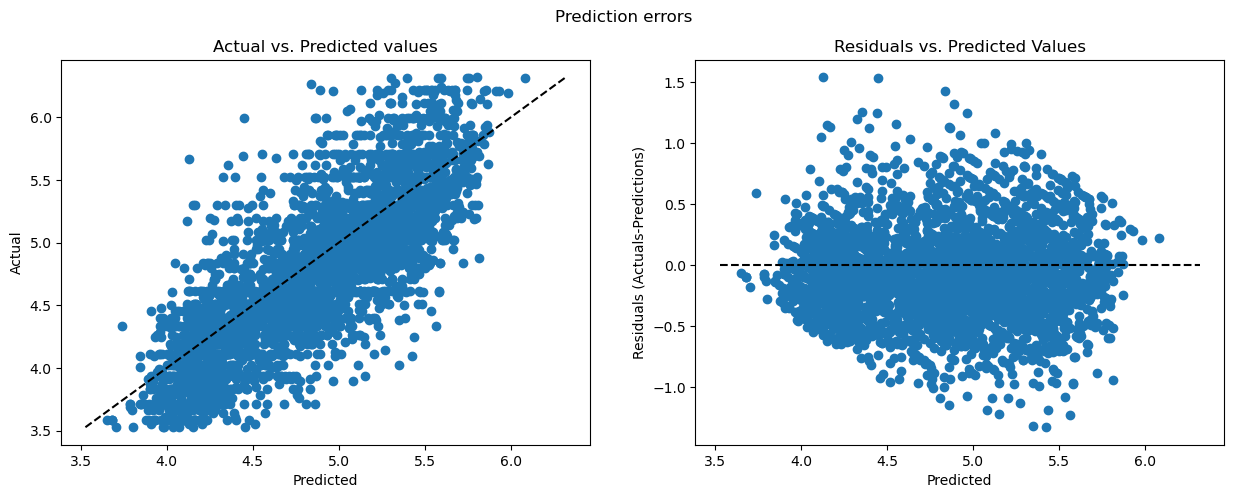

R²: 0.6428127499525695
MAE: 0.29320819724873526
MSE: 0.13881381584913371
RMSE: 0.3725772615835992
MAPE: 0.06315794406023037
error_ratio_rmse: 0.07863386725479148
error_ratio_mae: 0.061882720277872935


In [5]:
model_init = HistGradientBoostingRegressor(loss = "squared_error").fit(X_train_np, y_train_np)
y_pred = np.maximum(0,model_init.predict(X_test_np))

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [8]:
space={
        'max_iter': hp.choice('max_iter', range(50, 400)),
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'l2_regularization': hp.uniform('l2_regularization', 0.0, 500),
        'max_leaf_nodes' : hp.choice('max_leaf_nodes', range(3, 50)),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
        'loss': hp.choice('loss', ['squared_error', 'absolute_error', 'poisson']),
        'warm_start': hp.choice('warm_start', [True, False]),
        'random_state': hp.choice('random_state',range(0,400))
}


def objective(space):
    mod=HistGradientBoostingRegressor(**space,early_stopping=True, validation_fraction=0.1,n_iter_no_change=10)
    
    mod.fit(X_train_np, y_train_np)

    y_pred = mod.predict(X_test_np)
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

R²: 0.4642967496854222                                                                                                 
MAE: 41.748709860996975                                                                                                
MSE: 4792.541810219345                                                                                                 
RMSE: 69.22818652990519                                                                                                
MAPE: 0.2884075871680003                                                                                               
error_ratio_rmse: 0.5005310384577655                                                                                   
error_ratio_mae: 0.301849956620919                                                                                     
SCORE:                                                                                                                 
69.22818652990519                       

MAE: 43.59336622376469                                                                                                 
MSE: 4332.990969869762                                                                                                 
RMSE: 65.82545837189257                                                                                                
MAPE: 0.3493654974999352                                                                                               
error_ratio_rmse: 0.4759287609189223                                                                                   
error_ratio_mae: 0.31518712188748277                                                                                   
SCORE:                                                                                                                 
65.82545837189257                                                                                                      
R²: 0.5560069841868931                  

MSE: 4028.5205381133437                                                                                                
RMSE: 63.470627365052444                                                                                               
MAPE: 0.3255428758118491                                                                                               
error_ratio_rmse: 0.4589029500703733                                                                                   
error_ratio_mae: 0.30226908816351944                                                                                   
SCORE:                                                                                                                 
63.470627365052444                                                                                                     
R²: 0.5482552763606727                                                                                                 
MAE: 41.80559356429063                  

RMSE: 66.61400852716937                                                                                                
MAPE: 0.39071449680821607                                                                                              
error_ratio_rmse: 0.48163010668400646                                                                                  
error_ratio_mae: 0.32692823674878096                                                                                   
SCORE:                                                                                                                 
66.61400852716937                                                                                                      
R²: 0.49120477321195744                                                                                                
MAE: 40.49220663517027                                                                                                 
MSE: 4551.815572875146                  

MAPE: 0.32922384902774515                                                                                              
error_ratio_rmse: 0.4619328391044397                                                                                   
error_ratio_mae: 0.30433646551015464                                                                                   
SCORE:                                                                                                                 
63.88968973501367                                                                                                      
R²: 0.5323787046176304                                                                                                 
MAE: 42.67986817454262                                                                                                 
MSE: 4183.462781218729                                                                                                 
RMSE: 64.67969373163983                 

error_ratio_rmse: 0.4623827655139729                                                                                   
error_ratio_mae: 0.3051066708060937                                                                                    
SCORE:                                                                                                                 
63.95191882174496                                                                                                      
R²: 0.5548065307476607                                                                                                 
MAE: 41.43584248643059                                                                                                 
MSE: 3982.8175650894977                                                                                                
RMSE: 63.109567936165575                                                                                               
MAPE: 0.3218886386288307                

error_ratio_mae: 0.3055232881033667                                                                                    
SCORE:                                                                                                                 
63.95832057137668                                                                                                      
R²: 0.5578990995083968                                                                                                 
MAE: 41.34530966838033                                                                                                 
MSE: 3955.150633671587                                                                                                 
RMSE: 62.8899883421168                                                                                                 
MAPE: 0.31868507423205883                                                                                              
error_ratio_rmse: 0.45470483557847435   

In [6]:
best_hyperparams = {'l2_regularization': 106.37037927301648,
 'learning_rate': 0.04630469179014506,
 'loss': 'poisson',
 'max_depth': 8,
 'max_iter': 195,
 'max_leaf_nodes': 43,
 'min_samples_leaf': 7,
 'random_state': 189,
 'warm_start': 'False'}

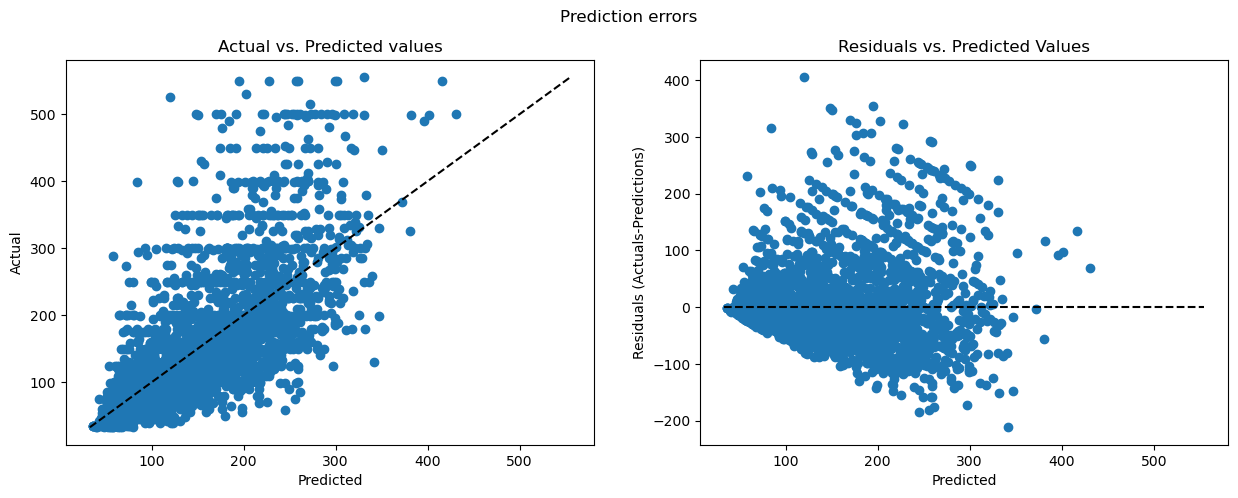

R²: 0.5590201629240139
MAE: 41.26763181495195
MSE: 3945.1213062629936
RMSE: 62.81020065453536
MAPE: 0.3194050595601385
error_ratio_rmse: 0.4541279576314544
error_ratio_mae: 0.29837168417098087


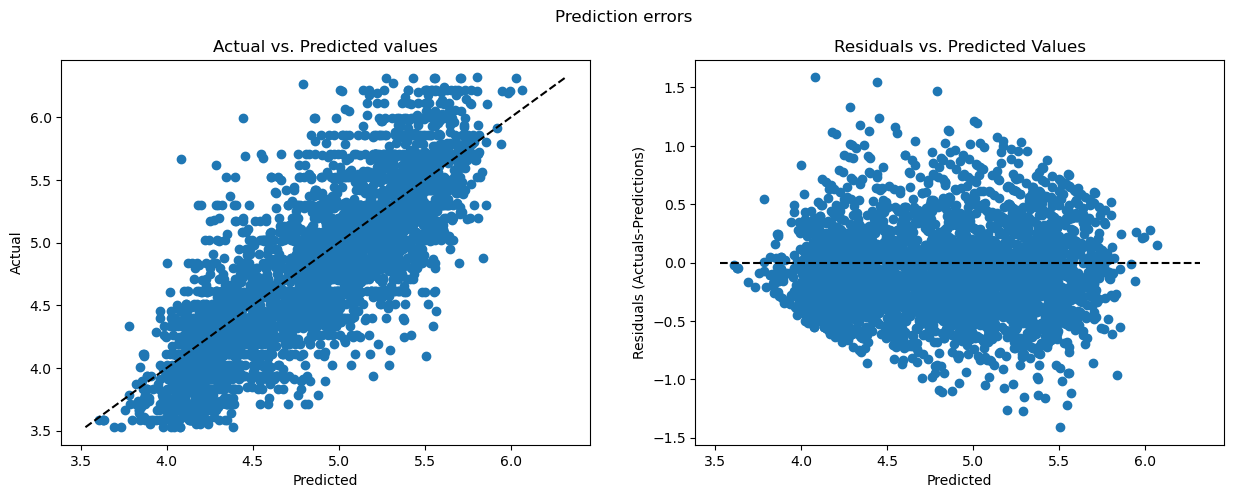

R²: 0.6525369963794667
MAE: 0.28786378630259674
MSE: 0.1350346782886646
RMSE: 0.3674706495608385
MAPE: 0.06185720703357096
error_ratio_rmse: 0.07755609710260149
error_ratio_mae: 0.06075476174624522


In [7]:
model_tuned = HistGradientBoostingRegressor(**best_hyperparams)

model_tuned.fit(X_train_np, y_train_np)

y_pred = np.maximum(0,model_tuned.predict(X_test_np))
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

# Save Model

In [8]:
sk_hist_gradboost_params = model_tuned.get_params()

# Save the parameters as a JSON file
with open('saved_models/sk_hist_gradient_boosting_params.json', 'w') as f:
    json.dump(sk_hist_gradboost_params, f)
